# CampaignSense — Modelagem Preditiva e Seleção do Modelo Campeão

Este notebook consolida a etapa de modelagem preditiva da POC CampaignSense, com foco na comparação estruturada de modelos e na seleção de um modelo capaz de sustentar decisões de campanha orientadas a lucro em contextos de CRM Analytics.

A avaliação prioriza a capacidade de ordenação de clientes, o impacto operacional do volume acionado e o ganho financeiro esperado, evitando otimização isolada de métricas técnicas.

## Escopo e regras do experimento

- Os dados utilizados foram preparados e particionados nas etapas anteriores da POC.
- O particionamento segue a lógica **train / validation / test**, com preservação da taxa de resposta.
- O conjunto de validação é utilizado para:
  - comparação entre modelos;
  - ajuste controlado de hiperparâmetros;
  - definição do threshold sob uma política explícita de ganho × custo.
- O conjunto de teste é mantido como **holdout final**, sem influência nas decisões de modelagem.
- São avaliados:
  - Regressão Logística (baseline de referência),
  - XGBoost,
  - LightGBM.
- A seleção do modelo campeão considera critérios integrados de:
  - ordenação do score (PR-AUC),
  - eficiência sob política de decisão fixa,
  - custo operacional, refletido no volume de clientes acionados.

## 1. Setup e carregamento dos dados

In [1]:
# Governança: habilita import de módulos do projeto a partir do diretório /notebooks
import sys
sys.path.insert(0, "..")

# Standard library
import json

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn (core)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

# Models (boosting)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Persistence
import joblib

# Local
from src.paths import (
    PLOTS_FOLDER,
    MODELS_FOLDER,
    METRICS_FOLDER,
    PROCESSED_TRAIN,
    PROCESSED_VALID,
    PROCESSED_TEST,
    PROCESSED_SPLIT_METADATA,
)

from src.evaluation import (
    evaluate_on_valid_profit,
    plot_pr_curve,
    plot_confusion_matrix,
)

In [2]:
# Governança: seed global para reprodutibilidade do notebook
SEED = 42
np.random.seed(SEED)

# Configuração de exibição (não altera a persistência dos dados)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
sns.set_theme(style="whitegrid", context="notebook")

In [3]:
# Carregamento dos datasets particionados
train = pd.read_parquet(PROCESSED_TRAIN)
valid = pd.read_parquet(PROCESSED_VALID)
test = pd.read_parquet(PROCESSED_TEST)

# Carregamento do metadata do particionamento
with open(PROCESSED_SPLIT_METADATA, "r", encoding="utf-8") as f:
    split_meta = json.load(f)

In [4]:
# Verificação inicial de dimensões
print(f"Split train: {train.shape[0]} linhas x {train.shape[1]} colunas")
print(f"Split valid: {valid.shape[0]} linhas x {valid.shape[1]} colunas")
print(f"Split test : {test.shape[0]} linhas x {test.shape[1]} colunas")

Split train: 1431 linhas x 31 colunas
Split valid: 358 linhas x 31 colunas
Split test : 448 linhas x 31 colunas


In [5]:
# Verificação split metadata
print(
    "Split meta | strategy:", split_meta.get("strategy"),
    "| seed:", split_meta.get("seed"),
    "| base_rate(train):", f'{split_meta["base_rate"]["train"]:.2%}',
    "| base_rate(valid):", f'{split_meta["base_rate"]["valid"]:.2%}',
    "| base_rate(test):",  f'{split_meta["base_rate"]["test"]:.2%}',
)

Split meta | strategy: stratified_random | seed: 42 | base_rate(train): 14.95% | base_rate(valid): 14.80% | base_rate(test): 14.96%


## 2. Preparação de features e variável alvo

In [6]:
TARGET_COL = "Response"
ID_COL = "ID"
DATE_COL = "Dt_Customer"

DROP_COLS = [ID_COL, TARGET_COL]
if DATE_COL in train.columns:
    DROP_COLS.append(DATE_COL)

print("DROP_COLS:", DROP_COLS)

DROP_COLS: ['ID', 'Response', 'Dt_Customer']


In [7]:
# Parâmetros (proxy) para comparação de modelos — valores provisórios
GAIN_PROXY = 11
COST_PROXY = 3

In [8]:
# Derivações determinísticas (features)
consumption_cols = [
    "MntWines", "MntFruits", "MntMeatProducts",
    "MntFishProducts", "MntSweetProducts", "MntGoldProds",
]

accepted_cols = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]

In [9]:
def add_deterministic_features(df):
    df = df.copy()
    df["TotalSpend"] = df[consumption_cols].sum(axis=1)
    df["AcceptedCmpTotal"] = df[accepted_cols].sum(axis=1)
    return df

In [10]:
#Split em X/y
X_train = train.drop(columns=DROP_COLS)
y_train = train[TARGET_COL].astype(int)

X_valid = valid.drop(columns=DROP_COLS)
y_valid = valid[TARGET_COL].astype(int)

X_test = test.drop(columns=DROP_COLS)
y_test = test[TARGET_COL].astype(int)

In [11]:
# Aplica derivações nos 3 splits
X_train = add_deterministic_features(X_train)
X_valid = add_deterministic_features(X_valid)
X_test  = add_deterministic_features(X_test)

In [12]:
{"TotalSpend" in X_train.columns, "AcceptedCmpTotal" in X_train.columns}

{True}

In [13]:
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_valid:", X_valid.shape, "| y_valid:", y_valid.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)

X_train: (1431, 30) | y_train: (1431,)
X_valid: (358, 30) | y_valid: (358,)
X_test : (448, 30) | y_test : (448,)


In [14]:
# Tipos (para ColumnTransformer)
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

Numéricas: 28 | Categóricas: 2


## 3. Treino e avaliação comparativa dos modelos candidatos

Nesta etapa, são treinados e avaliados modelos preditivos para comparação direta com o baseline de Regressão Logística, mantendo o foco da POC em priorização de clientes e maximização de retorno financeiro.

A avaliação concentra-se em um conjunto restrito de abordagens representativas e amplamente utilizadas em CRM Analytics e Marketing Science, com aplicabilidade comprovada em contextos operacionais de marketing orientado a dados.

Os modelos candidatos são selecionados com base nos seguintes critérios técnicos:

- desempenho adequado em dados tabulares com resposta desbalanceada;
- capacidade de gerar scores ordenáveis, apropriados para priorização;
- robustez a relações não lineares entre variáveis comportamentais;
- uso recorrente em sistemas reais de targeting e recomendação.

O protocolo experimental é mantido consistente ao longo de todos os modelos, assegurando comparabilidade direta dos resultados:

- treinamento restrito ao conjunto de treino;
- avaliação realizada exclusivamente no conjunto de validação;
- ausência de validação cruzada aleatória, em conformidade com o desenho do pipeline;
- utilização da mesma lógica de avaliação orientada a lucro (proxy) definida no baseline.

A partir deste enquadramento, cada modelo é analisado individualmente sob a mesma política de decisão.

### 3.1. Baseline — Regressão Logística

A Regressão Logística é adotada como baseline de referência, estabelecendo o nível mínimo aceitável de desempenho para a POC.

Seu papel é fornecer um ponto de comparação estável e interpretável, permitindo avaliar se abordagens mais complexas entregam ganho incremental relevante sob a ótica de priorização orientada a valor.

In [15]:
# Preprocessamento Baseline
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

In [16]:
# Pipeline baseline
baseline_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            random_state=SEED
        ))
    ]
)

In [17]:
# Treinamento
baseline_model.fit(X_train, y_train)

# Probabilidades no conjunto de validação
p_valid_baseline = baseline_model.predict_proba(X_valid)[:, 1]

In [18]:
auc_baseline = roc_auc_score(y_valid, p_valid_baseline)
pr_auc_baseline = average_precision_score(y_valid, p_valid_baseline)

print(f"Baseline | ROC-AUC: {auc_baseline:.4f} | PR-AUC: {pr_auc_baseline:.4f}")

Baseline | ROC-AUC: 0.8985 | PR-AUC: 0.6100


In [19]:
# Avaliação orientada a lucro (proxy)
baseline_eval = evaluate_on_valid_profit(
    model_name="logreg_baseline",
    y_valid=y_valid,
    proba_valid=p_valid_baseline,
    gain=GAIN_PROXY,
    cost=COST_PROXY,
)

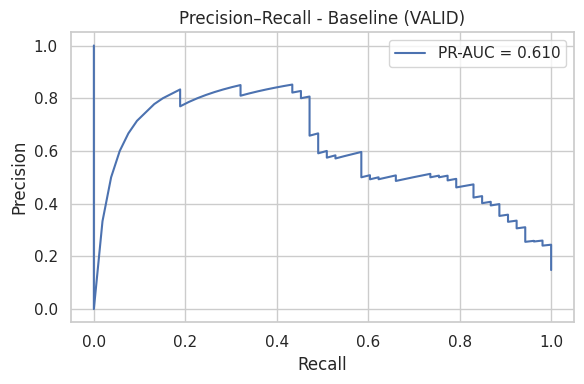

In [20]:
# PR Curve - Baseline (VALID)
_ = plot_pr_curve(
    y_valid,
    p_valid_baseline,
    title="Precision–Recall - Baseline (VALID)",
    savepath=None,
)

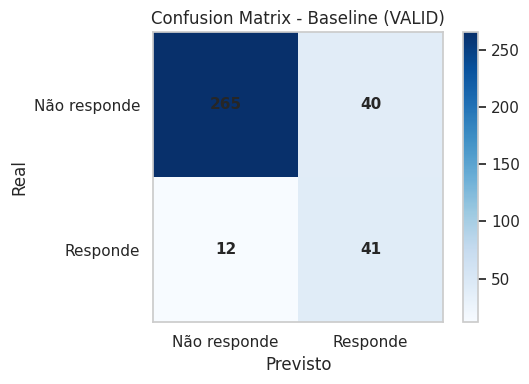

In [21]:
# Confusion Matrix - Baseline (VALID)
plot_confusion_matrix(
    cm=baseline_eval["confusion_matrix_valid"],
    title="Confusion Matrix - Baseline (VALID)",
    savepath=None,
)

In [22]:
baseline_summary = {
    "model": baseline_eval["model"],
    "pr_auc_valid": baseline_eval["pr_auc_valid"],
    "best_threshold_valid": baseline_eval["best_threshold_valid"],
    "expected_profit_valid": baseline_eval["expected_profit_valid"],
    "selected_valid": baseline_eval["selected_valid"],
    "selected_rate_valid": baseline_eval["selected_rate_valid"],
}

pd.DataFrame([baseline_summary])

,model,pr_auc_valid,best_threshold_valid,expected_profit_valid,selected_valid,selected_rate_valid
0,logreg_baseline,0.6100,0.5700,208.0000,81,0.2263


### 3.2. Modelo candidato — LightGBM

O LightGBM é avaliado como modelo candidato por sua recorrência em aplicações de CRM Analytics e targeting em dados tabulares.

No contexto desta POC, é considerado uma alternativa com bom equilíbrio entre capacidade preditiva, ordenação de scores e controle do volume acionado, características relevantes em cenários com restrições operacionais.

In [23]:
# Prepocessamento LightGBM
preprocess_lgbm = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

In [24]:
# Pipeline LightGBM
lgbm_model = Pipeline(
    steps=[
        ("preprocess", preprocess_lgbm),
        ("model", LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.0,
            reg_lambda=1.0,
            random_state=SEED,
            n_jobs=-1,
        ))
    ]
)

In [25]:
# Treinamento
lgbm_model.fit(X_train, y_train)

# Probabilidades no conjunto de validação
p_valid_lgbm = lgbm_model.predict_proba(X_valid)[:, 1]

[LightGBM] [Info] Number of positive: 214, number of negative: 1217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 1431, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149546 -> initscore=-1.738168
[LightGBM] [Info] Start training from score -1.738168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [26]:
auc_lgbm = roc_auc_score(y_valid, p_valid_lgbm)
pr_auc_lgbm = average_precision_score(y_valid, p_valid_lgbm)

print(f"LGBM | ROC-AUC: {auc_lgbm:.4f} | PR-AUC: {pr_auc_lgbm:.4f}")

LGBM | ROC-AUC: 0.9081 | PR-AUC: 0.6655


In [27]:
# Avaliação orientada a lucro (proxy)
lgbm_eval = evaluate_on_valid_profit(
    model_name="lightgbm",
    y_valid=y_valid,
    proba_valid=p_valid_lgbm,
    gain=GAIN_PROXY,
    cost=COST_PROXY,
)

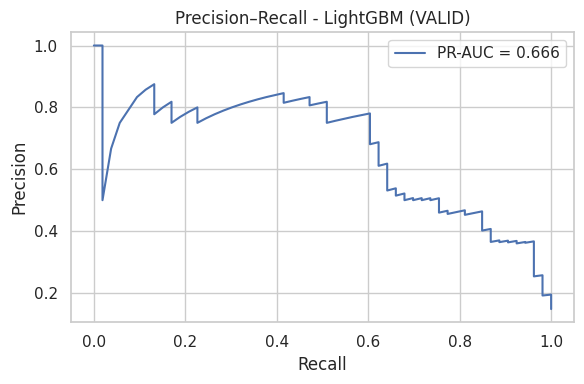

In [28]:
# PR Curve - LightGBM (VALID)
_ = plot_pr_curve(
    y_valid,
    p_valid_lgbm,
    title="Precision–Recall - LightGBM (VALID)",
    savepath=None,
)

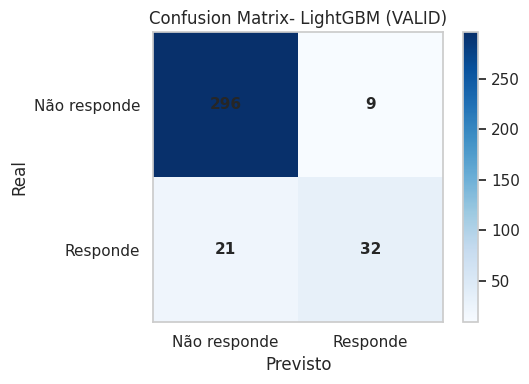

In [29]:
# Confusion Matrix - LightGBM (VALID)
cm_baseline = lgbm_eval["confusion_matrix_valid"]
plot_confusion_matrix(
    cm=cm_baseline,
    title="Confusion Matrix- LightGBM (VALID)",
    savepath=None,
)

In [30]:
lgbm_summary = {
    "model": lgbm_eval["model"],
    "pr_auc_valid": lgbm_eval["pr_auc_valid"],
    "best_threshold_valid": lgbm_eval["best_threshold_valid"],
    "expected_profit_valid": lgbm_eval["expected_profit_valid"],
    "selected_valid": lgbm_eval["selected_valid"],
    "selected_rate_valid": lgbm_eval["selected_rate_valid"],
}

pd.DataFrame([lgbm_summary])

,model,pr_auc_valid,best_threshold_valid,expected_profit_valid,selected_valid,selected_rate_valid
0,lightgbm,0.6655,0.3300,229.0000,41,0.1145


### 3.3. Modelo candidato — XGBoost

O XGBoost é avaliado como modelo candidato de maior capacidade, com uso recorrente em problemas de ranking, priorização e score de propensão.

Sua inclusão permite avaliar o impacto de modelos mais expressivos na captura de relações não lineares e na geração de scores bem ordenados, critério central para decisões orientadas a lucro.

In [31]:
# Preprocessamento XGBoost
preprocess_xgb = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

In [32]:
# Pipeline XGBoost
xgb_model = Pipeline(
    steps=[
        ("preprocess", preprocess_xgb),
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.0,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=SEED,
            n_jobs=-1,
        ))
    ]
)

In [33]:
# Treinamento
xgb_model.fit(X_train, y_train)

# Probabilidades no conjunto de validação
p_valid_xgb = xgb_model.predict_proba(X_valid)[:, 1]

In [34]:
auc_xgb = roc_auc_score(y_valid, p_valid_xgb)
pr_auc_xgb = average_precision_score(y_valid, p_valid_xgb)

print(f"XGBoost | ROC-AUC: {auc_xgb:.4f} | PR-AUC: {pr_auc_xgb:.4f}")

XGBoost | ROC-AUC: 0.9078 | PR-AUC: 0.6820


In [35]:
# Avaliação orientada a lucro (proxy)
xgb_eval = evaluate_on_valid_profit(
    model_name="xgboost",
    y_valid=y_valid,
    proba_valid=p_valid_xgb,
    gain=GAIN_PROXY,
    cost=COST_PROXY,
)

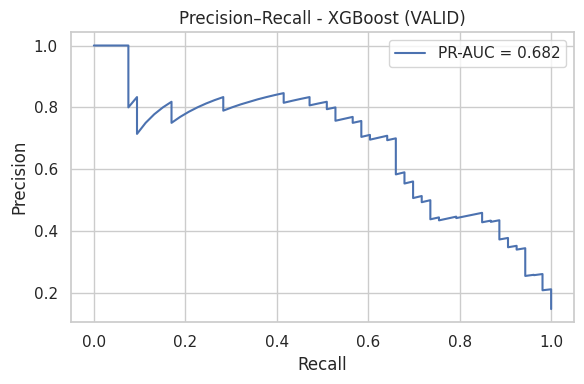

In [36]:
# PR Curve - XGBooost (VALID)
_ = plot_pr_curve(
    y_valid,
    p_valid_xgb,
    title="Precision–Recall - XGBoost (VALID)",
    savepath=PLOTS_FOLDER / "pr_curve_valid_xgboost.png",
)

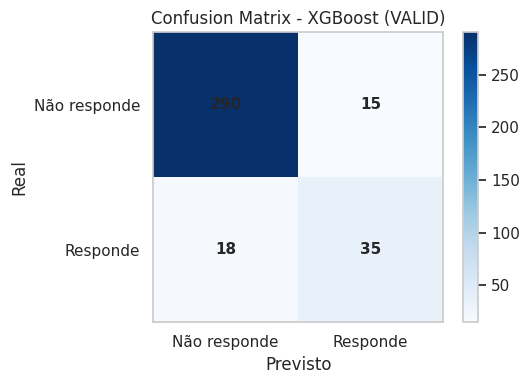

In [37]:
# Confusion Matrix - XGBoost (VALID) 
_ = plot_confusion_matrix(
    cm=xgb_eval["confusion_matrix_valid"],
    title="Confusion Matrix - XGBoost (VALID)",
    savepath=PLOTS_FOLDER / "confusion_valid_xgboost.png",
)

In [38]:
xgb_summary = {
    "model": xgb_eval["model"],
    "pr_auc_valid": xgb_eval["pr_auc_valid"],
    "best_threshold_valid": xgb_eval["best_threshold_valid"],
    "expected_profit_valid": xgb_eval["expected_profit_valid"],
    "selected_valid": xgb_eval["selected_valid"],
    "selected_rate_valid": xgb_eval["selected_rate_valid"],
}

pd.DataFrame([xgb_summary])

,model,pr_auc_valid,best_threshold_valid,expected_profit_valid,selected_valid,selected_rate_valid
0,xgboost,0.6820,0.2700,235.0000,50,0.1397


### 3.4. Tabela comparativa e escolha do campeão

In [39]:
results_df = pd.DataFrame([
    baseline_summary,
    xgb_summary,
    lgbm_summary,
]).sort_values(by="pr_auc_valid", ascending=False)

results_df

,model,pr_auc_valid,best_threshold_valid,expected_profit_valid,selected_valid,selected_rate_valid
1,xgboost,0.6820,0.2700,235.0000,50,0.1397
2,lightgbm,0.6655,0.3300,229.0000,41,0.1145
0,logreg_baseline,0.6100,0.5700,208.0000,81,0.2263


## 4. Seleção do modelo campeão (performance × custo operacional)

Após o treinamento e a avaliação dos modelos candidatos no conjunto de validação, sob um protocolo experimental consistente, é realizada a comparação entre o baseline de Regressão Logística e os modelos de gradient boosting (XGBoost e LightGBM).

A seleção do modelo campeão é conduzida sob uma abordagem orientada à decisão, na qual todos os modelos são avaliados sob a mesma política de profit targeting, com definição de threshold baseada na maximização do lucro esperado (proxy), e não em métricas técnicas isoladas.

A comparação entre os modelos adota de forma integrada os seguintes critérios:

- capacidade de ordenação do score, avaliada por meio do PR-AUC;
- eficiência preditiva no threshold selecionado, refletida no equilíbrio entre verdadeiros positivos e falsos positivos;
- custo operacional da campanha, representado pela fração da base selecionada para ação;
- impacto financeiro esperado, utilizado como critério final de decisão.

O modelo campeão é definido como aquele que apresenta o melhor compromisso entre ordenação do score, eficiência operacional e impacto financeiro esperado, em conformidade com o objetivo da POC CampaignSense.

In [40]:
results_df_sorted = (
    results_df
      # Ordenação hierárquica para seleção do modelo campeão
      # 1) maior lucro esperado no conjunto de validação
      # 2) maior capacidade de ordenação do score (PR-AUC)
      # 3) menor fração da base selecionada (custo operacional)
      .sort_values(
          by=["expected_profit_valid", "pr_auc_valid", "selected_rate_valid"],
          ascending=[False, False, True]
      )
      .reset_index(drop=True)
)

results_df_sorted

,model,pr_auc_valid,best_threshold_valid,expected_profit_valid,selected_valid,selected_rate_valid
0,xgboost,0.6820,0.2700,235.0000,50,0.1397
1,lightgbm,0.6655,0.3300,229.0000,41,0.1145
2,logreg_baseline,0.6100,0.5700,208.0000,81,0.2263


### Conclusão - Modelo campeão (XGBoost)

A comparação entre os modelos é conduzida de forma consistente no conjunto de validação, utilizando a mesma política de decisão orientada a lucro (proxy) e o mesmo protocolo experimental.

O XGBoost é selecionado como modelo campeão por apresentar o melhor resultado no critério central da POC, conforme evidenciado por:

- maior lucro esperado no conjunto de validação (235);
- boa capacidade de ordenação do score (PR-AUC valid = 0.682);
- menor volume acionado em relação ao baseline, com taxa de seleção de 13,97% da base (50 clientes), reduzindo custo operacional.

O LightGBM apresenta um perfil mais conservador, com menor taxa de seleção, porém com lucro esperado inferior (229).  
A Regressão Logística permanece como baseline de referência e validação de simplicidade.

A partir deste ponto, o modelo campeão é submetido à validação final no conjunto de teste, sem ajuste adicional de threshold.

## 5. Avaliação final no conjunto de teste (holdout)

Nesta etapa, o modelo campeão é avaliado no conjunto de teste (holdout), utilizado uma única vez ao final do pipeline.

As seguintes diretrizes são adotadas para esta avaliação:

- o conjunto TEST não é utilizado para ajustes de modelo, seleção de threshold ou tuning;
- o threshold aplicado no TEST é o mesmo definido no conjunto de validação;
- a avaliação tem como finalidade verificar a estabilidade do trade-off entre performance e custo operacional fora do conjunto de validação.

In [41]:
# Score do campeão no TEST
p_test_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [42]:
roc_auc_test = roc_auc_score(y_test, p_test_xgb)
pr_auc_test = average_precision_score(y_test, p_test_xgb)

print(f"XGBoost (TEST) | ROC-AUC: {roc_auc_test:.4f} | PR-AUC: {pr_auc_test:.4f}")


XGBoost (TEST) | ROC-AUC: 0.9062 | PR-AUC: 0.6399


In [43]:
# Usa o threshold escolhido no VALID para simular generalização (não “reaprende” política no TEST)

# recupera o cutoff ótimo encontrado na validação
thr_valid = xgb_eval["best_threshold_valid"] 

 # aplica a política do VALID no TEST: score >= cutoff → 1 (seleciona), senão 0
y_pred_test = (p_test_xgb >= thr_valid).astype(int) 

  # calcula a matriz de confusão no TEST com esse cutoff fixo
cm_test = confusion_matrix(y_test, y_pred_test)

  # extrai os 4 números da matriz 2x2: TN, FP, FN, TP (nesta ordem)
tn, fp, fn, tp = cm_test.ravel()

selected_test = int(y_pred_test.sum())  # total de clientes selecionados para ação no TEST (quantos 1’s)
selected_rate_test = selected_test / len(y_test)  # fração da base do TEST que seria acionada (taxa de seleção)

expected_profit_test = tp * GAIN_PROXY - selected_test * COST_PROXY  # aplica a fórmula de profit targeting com threshold do VALID

In [44]:
test_eval = {
    "model": "xgboost", 
    "threshold_from_valid": float(thr_valid),
    "roc_auc_test": float(roc_auc_test), 
    "pr_auc_test": float(pr_auc_test), 
    "expected_profit_test": float(expected_profit_test), 
    "selected_test": int(selected_test),  
    "selected_rate_test": float(selected_rate_test),  
    "confusion_matrix_test": cm_test,
}

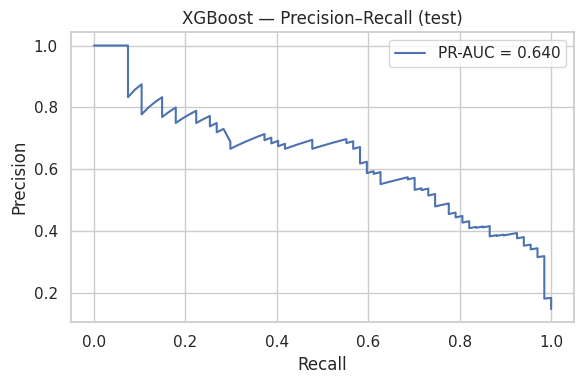

In [45]:
# PR Curve - XGBooost (TEST)
_ = plot_pr_curve(
    y_test,
    p_test_xgb,
    title="XGBoost — Precision–Recall (test)",
)

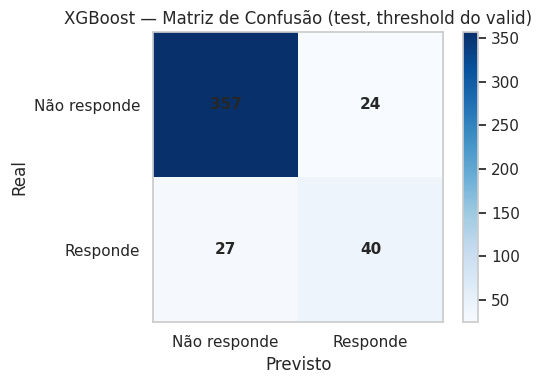

In [46]:
# Confusion Matrix - XGBoost (TEST)
_ = plot_confusion_matrix(
    test_eval["confusion_matrix_test"],
    title="XGBoost — Matriz de Confusão (test, threshold do valid)",
    savepath=PLOTS_FOLDER / "confusion_test_xgboost.png",
)

### Interpretação (TEST)

O conjunto de teste é utilizado exclusivamente para validação final do modelo campeão, mantendo o mesmo threshold definido no conjunto de validação, sem reotimização de parâmetros ou alteração da política de decisão.

Os resultados observados indicam comportamento consistente em dados não vistos, preservando o trade-off estabelecido na etapa de validação.

* **PR-AUC (TEST = 0.640)** indica manutenção da capacidade de ordenação do score fora da amostra de validação.
* **ROC-AUC (TEST = 0.906)** confirma a estabilidade do poder discriminativo global do modelo.
* A **taxa de seleção (~14,3%)**, aplicada com o threshold herdado da validação, permanece alinhada ao nível operacional esperado.
* A **matriz de confusão** apresenta equilíbrio consistente entre capturas relevantes (TP = 40) e controle de falsos positivos (FP = 24).
* O **lucro esperado no conjunto de teste (proxy = 248)** é compatível com o observado na validação, indicando generalização adequada do ganho estimado.

A estabilidade observada entre validação e teste confirma a adequação do modelo para uso nas etapas subsequentes da POC.

## 6. Persistência do modelo campeão e artefatos

In [47]:
champion_model = MODELS_FOLDER / "xgb_model.joblib"
joblib.dump(xgb_model, champion_model)

['/home/jhonathan/sdl/POC/campaignsense/models/xgb_model.joblib']

In [48]:
# Persistir métricas consolidadas (valid + test)
metrics_payload = {
    "valid": {
        "pr_auc_valid": float(xgb_eval["pr_auc_valid"]),
        "best_threshold_valid": float(xgb_eval["best_threshold_valid"]),
        "expected_profit_valid": float(xgb_eval["expected_profit_valid"]),
        "selected_valid": int(xgb_eval["selected_valid"]),
        "selected_rate_valid": float(xgb_eval["selected_rate_valid"]),
        "confusion_matrix_valid": xgb_eval["confusion_matrix_valid"].tolist(),
        "gain_proxy": float(GAIN_PROXY),
        "cost_proxy": float(COST_PROXY),
    },
    "test": {
        "threshold_from_valid": float(test_eval["threshold_from_valid"]),
        "roc_auc_test": float(test_eval["roc_auc_test"]),
        "pr_auc_test": float(test_eval["pr_auc_test"]),
        "expected_profit_test": float(test_eval["expected_profit_test"]),
        "selected_test": int(test_eval["selected_test"]),
        "selected_rate_test": float(test_eval["selected_rate_test"]),
        "confusion_matrix_test": test_eval["confusion_matrix_test"].tolist(),
        "gain_proxy": float(GAIN_PROXY),
        "cost_proxy": float(COST_PROXY),
    },
}

In [49]:
champion_metrics = METRICS_FOLDER / "xgb_model_metrics.json"
with open(champion_metrics, "w", encoding="utf-8") as f:
    json.dump(metrics_payload, f, ensure_ascii=False, indent=2)

## Encerramento

Este notebook consolida a etapa de modelagem preditiva da POC CampaignSense, com foco na seleção de um modelo capaz de sustentar decisões de campanha orientadas a lucro.

Ao término desta etapa, a POC passa a dispor de:

* treinamento e avaliação comparativa de modelos candidatos (Regressão Logística, XGBoost e LightGBM), conduzidos sob um mesmo protocolo experimental;
* definição de um baseline interpretável como referência mínima de desempenho;
* seleção do modelo campeão (XGBoost) com base em critérios integrados de ordenação do score (PR-AUC), eficiência sob política de decisão fixa e custo operacional;
* definição e fixação de um threshold no conjunto de validação, alinhado a uma política explícita de ganho × custo;
* avaliação final do modelo campeão no conjunto de teste (holdout), sem recalibração, para verificação de consistência e generalização;
* persistência dos artefatos do modelo campeão, métricas finais e evidências visuais.

Com isso, a CampaignSense passa a contar com um modelo preditivo validado e estável, disponível para integração nas etapas subsequentes da POC.